In [ ]:
#!/bin/bash
!kaggle datasets download moltean/fruits

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Normalize, Compose, Grayscale
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import os
import time

VALIDATION = 0.2
FASHION_BATCH_SIZE = 200
matrix_transforms = v2.Compose([
    ToTensor(),
    Resize((64, 64)),
    # Normalize(0.5, 0.5),
])


class EarlyStopping():
    def __init__(self, path : str, patience=5, threshold=1e-4):
        self.patience = patience
        self.threshold = threshold
        self.min_loss = 10000
        self.steps_till_stop = 0
        self.path = path

    def continue_training(self, model, loss):
        if(loss < self.min_loss - self.threshold):
            self.min_loss = loss
            self.steps_till_stop = 0
            torch.save(model.state_dict(), self.path)
            return True
        if (loss >= self.min_loss - self.threshold):
            self.steps_till_stop += 1
            if (self.steps_till_stop == self.patience): return False
        return True
    
    def load_model(self, model):
        model.load_state_dict(torch.load(self.path, weights_only=True))
        return model



def plot_losses(train_losses: list[float], validation_losses: list[float], label_x : str, label_y : str, title : str) -> None:
    """Plots training and validation losses over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label=label_x, marker="o")
    plt.plot(validation_losses, label=label_y, marker="o")
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def get_fashion_dataloader(size : int):
    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=matrix_transforms)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=matrix_transforms)
    train_dataloader = DataLoader(train_data, batch_size=size, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=size, shuffle=False)
    return train_data, test_data, train_dataloader, test_dataloader

train_fashion_dataset, test_fashion_dataset, train_fashion_dataloader, test_fashion_dataloader = get_fashion_dataloader(FASHION_BATCH_SIZE)
FASHION_KEYS = np.unique(train_fashion_dataset.targets)

In [2]:
class InfoLoaderDataset(Dataset):
    def __init__(self, data, labels, num_classes, transforms = None):
        self.data = data
        self.labels = labels
        self.num_classes = num_classes
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.transforms == None):
            return self.data[idx], self.labels[idx]
        data = self.data[idx].detach().numpy()
        return self.transforms(data), self.labels[idx]

def initialiseTrainingModelHelpers(model, parameters):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr_optimizer'], weight_decay=parameters['weight_decay_factor'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                    factor=parameters['gamma_lr'], patience=parameters['patience'], verbose=True)
    return criterion, optimizer, lr_scheduler

def train(model, dataloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    model.to(device)
    train_loss = 0
    all_preds = []
    all_labels= []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.type(torch.float32)
        labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return train_loss / len(dataloader), accuracy_score(all_preds, all_labels)

def test(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        all_preds = []
        all_labels= []
        for inputs, labels in dataloader:
            inputs = inputs.type(torch.float32)
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            validation_loss += criterion(out, labels).item()
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        return validation_loss / len(dataloader), accuracy_score(all_preds, all_labels), all_preds, all_labels

def train_model(model, data, criterion, optimizer, lr_scheduler, epochs, early_stopper : EarlyStopping):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    max_acc = 0
    for i in range(epochs):
        train_loss, train_acc = train(model, data["train"], optimizer, criterion)
        val_loss, val_acc, _, _ = test(model, data["validation"], criterion)
        time.sleep(2)
        if (val_acc > max_acc):
            max_acc = val_acc
            print("acuratete maxima la epoca", i)
        lr_scheduler.step(val_loss)
        print(val_loss, val_acc, "epoch: ", i)
        train_info["train_loss"].append(train_loss)
        train_info["validation_loss"].append(val_loss)
        train_info["train_accuracy"].append(train_acc)
        train_info["validation_accuracy"].append(val_acc)
        if not early_stopper.continue_training(model, val_loss): break
    return train_info

def test_model(model, dataloader, criterion, for_fruits):
    loss, accuracy, pred, labels = test(model, dataloader, criterion)
    print("loss was:", loss, " accuracy was:", accuracy)
    print()
    out = {
        "f1": f1_score(labels, pred, labels=range(0, 10), average='macro'),
        "recall": recall_score(labels, pred, labels=range(0, 10), average='macro'),
        "precision": precision_score(labels, pred, labels=range(0, 10), average='macro'),
        "accuracy": accuracy,
    }
    print(out)
    if for_fruits == False:
        return out, confusion_matrix(labels, pred),
    return out


def execute_pipeline(model, data, parameters, early_stopper, for_fruits=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion, optimizer, lr_scheduler = initialiseTrainingModelHelpers(model, parameters)
    train_info = train_model(model, data, criterion, optimizer,
                             lr_scheduler, parameters['epochs'], early_stopper)
    plot_losses(train_info["train_loss"], train_info["validation_loss"], 
                "Epochs", "Loss", "Training and Validation Loss")
    plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], 
                "Epochs", "Accuracy", "Training and Validation Accuracy")
    model = early_stopper.load_model(model)
    return test_model(model, data["test"], criterion, for_fruits)


In [3]:
# Task 1
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from task1_aux import compute_vocabulary, create_initial_features, compute_attributes
pd.set_option("display.precision", 15)
SIZE = (28, 28)
BATCH_SIZE = 100
# DE ADAUGAT TRANSFORMARI
vocabulary = compute_vocabulary(train_fashion_dataloader, 5)
print(vocabulary.shape)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, y_train = create_initial_features(train_fashion_dataloader, vocabulary)
X_test, y_test = create_initial_features(test_fashion_dataloader, vocabulary)
rf.fit(X_train, y_train)
accuracy_before = rf.score(X_test, y_test)
print(f'accuracy after one more step', accuracy_before)
importances = rf.feature_importances_
feature_names = range(vocabulary.shape[0])
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df['Feature'][:64].values
vocabulary = vocabulary[top_features]
X_train, y_train, X_validation, y_validation, X_test, y_test = compute_attributes(vocabulary,
                            train_fashion_dataloader,  test_fashion_dataloader, FASHION_KEYS, VALIDATION)
data = {
    "train":  DataLoader(InfoLoaderDataset(X_train, y_train, 10), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10), BATCH_SIZE, shuffle=True),
    "test": DataLoader(InfoLoaderDataset(X_test, y_test, 10), BATCH_SIZE, shuffle=True),
}
print(vocabulary.shape)

a ajuns la epoca: 0
a ajuns la epoca: 100
a ajuns la epoca: 200
(1500, 36)
accuracy after one more step 0.6696
(60000, 64) (60000,)
(10000, 64) (10000,)
(64, 36)


In [3]:
class FeaturesMLP(nn.Module):
    def __init__(self, expansion, initial_features, num_classes=10):
        super(FeaturesMLP, self).__init__()
        width1 = initial_features
        width2  = width1 * expansion
        self.fc1 = nn.Linear(width1, width2)
        self.bn1 = nn.BatchNorm1d(width2)

        width3 = width2 * expansion
        self.fc2 = nn.Linear(width2, width3)
        self.bn2 = nn.BatchNorm1d(width3)

        width4 = width3 * expansion
        self.fc3 = nn.Linear(width3, width4)
        self.bn3 = nn.BatchNorm1d(width4)

        self.fc4 = nn.Linear(width4, width3)
        self.bn4 = nn.BatchNorm1d(width3)

        self.fc5 = nn.Linear(width3, width2)
        self.bn5 = nn.BatchNorm1d(width2)

        self.fc6 = nn.Linear(width2, width1)
        self.bn6 = nn.BatchNorm1d(width1)

        self.fc7 = nn.Linear(width1, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = self.bn1(self.relu(self.fc1(x)))
        x = self.bn2(self.relu(self.fc2(x)))
        x = self.bn3(self.relu(self.fc3(x)))
        x = self.bn4(self.relu(self.fc4(x)))
        x = self.bn5(self.relu(self.fc5(x)))
        x = self.bn6(self.relu(self.fc6(x)))
        return self.softmax(self.fc7(x))
    
parameters = {
    'expansion': 2,
    'epochs' : 50,
    'lr_optimizer': 1e-5,
    'gamma_lr': 0.3,
    'weight_decay_factor': 1e-4,
    'patience': 3,
    'early_stopper': 7,
}
model = FeaturesMLP(expansion=parameters['expansion'], initial_features=64)
for module in model.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")

Layer Type: FeaturesMLP(
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (bn6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc7): Linear(in_features=64, out_features=10, bias=True)
  (rel

In [12]:
early_stopper = EarlyStopping("./task1.pth", parameters['early_stopper'])
results_task1_fashion, task1_mat_fashion = execute_pipeline(model, data, parameters, early_stopper)
disp = ConfusionMatrixDisplay(confusion_matrix=task1_mat_fashion, display_labels=range(0, 10))
disp.plot()
plt.show()

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2800x28 and 64x256)

In [13]:
# Task 2
from task1_aux import split_data_in_training_validation
SIZE = (28, 28)
BATCH_SIZE = 100

class FullImageMLP(nn.Module):
    def __init__(self, input_size, num_hidden_layers : int, num_classes=10):
        super(FullImageMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, num_hidden_layers)
        self.bn1 = nn.BatchNorm1d(num_hidden_layers)
        self.fc2 = nn.Linear(num_hidden_layers, num_hidden_layers)
        self.bn2 = nn.BatchNorm1d(num_hidden_layers)
        self.fc3 = nn.Linear(num_hidden_layers, num_hidden_layers // 2)
        self.bn3 = nn.BatchNorm1d(num_hidden_layers // 2)
        self.fc4 = nn.Linear(num_hidden_layers // 2, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = torch.flatten(x, start_dim=1)
        x = self.bn1(self.relu(self.fc1(x)))
        x = self.bn2(self.relu(self.fc2(x)))
        x = self.bn3(self.relu(self.fc3(x)))
        return self.softmax(self.fc4(x))

transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5),
])

X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
data = {
    "train" : DataLoader(InfoLoaderDataset(X_train, y_train, 10, transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, transforms), BATCH_SIZE, shuffle=True),
    "test": DataLoader(InfoLoaderDataset(X_test, y_test, 10, transforms), BATCH_SIZE, shuffle=True)
}

parameters = {
    'epochs' : 50,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.3,
    'weight_decay_factor': 1e-4,
    'patience': 3,
    'early_stopper': 6,
}

model = FullImageMLP(input_size=784, num_hidden_layers=350)
for module in model.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")

Layer Type: FullImageMLP(
  (fc1): Linear(in_features=784, out_features=350, bias=True)
  (bn1): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=350, out_features=350, bias=True)
  (bn2): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=350, out_features=175, bias=True)
  (bn3): BatchNorm1d(175, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=175, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (softmax): Softmax(dim=1)
), Number of Parameters: 462535
Layer Type: Linear(in_features=784, out_features=350, bias=True), Number of Parameters: 274750
Layer Type: BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Number of Parameters: 700
Layer Type: Linear(in_features=350, out_features=350, bias=True), Number of Parameters: 122850
Layer Type: BatchNorm1d(350, eps=1e-05, momentum=0.1, affi

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
1.626127682129542 0.8523333333333334 epoch:  0
acuratete maxima la epoca 1
1.6093832939863204 0.86275 epoch:  1
acuratete maxima la epoca 2
1.5991681665182114 0.8685 epoch:  2
acuratete maxima la epoca 3
1.5962222208579382 0.87125 epoch:  3
1.5948433647553126 0.8695 epoch:  4
acuratete maxima la epoca 5
1.5830280214548111 0.88075 epoch:  5
acuratete maxima la epoca 6
1.583078603943189 0.88125 epoch:  6
1.5848509202400842 0.8790833333333333 epoch:  7
acuratete maxima la epoca 8
1.5838052928447723 0.8815833333333334 epoch:  8
acuratete maxima la epoca 9
1.5801566700140635 0.8831666666666667 epoch:  9
acuratete maxima la epoca 10
1.5793357898791631 0.8838333333333334 epoch:  10
acuratete maxima la epoca 11
1.5777370065450669 0.8865 epoch:  11
acuratete maxima la epoca 12
1.577239007751147 0.8870833333333333 epoch:  12
1.576842975616455 0.8870833333333333 epoch:  13
1.576643380522728 0.88675 epoch:  14
acuratete maxima la epoca 15
1.5737828155358633 0.88925 epoc

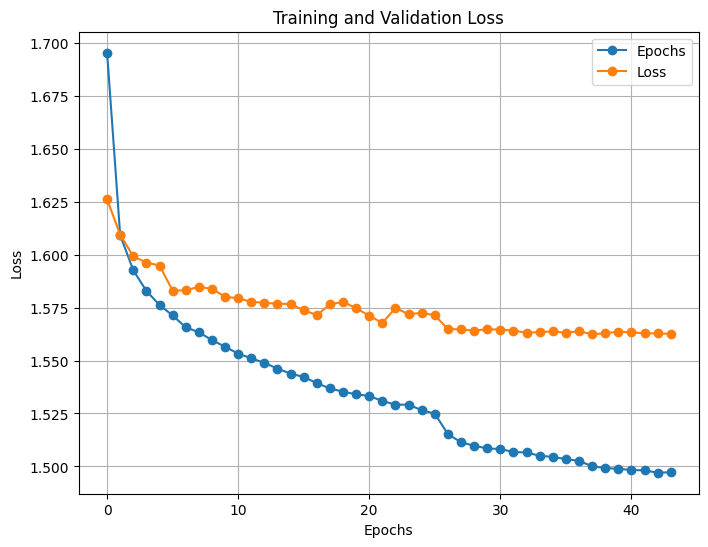

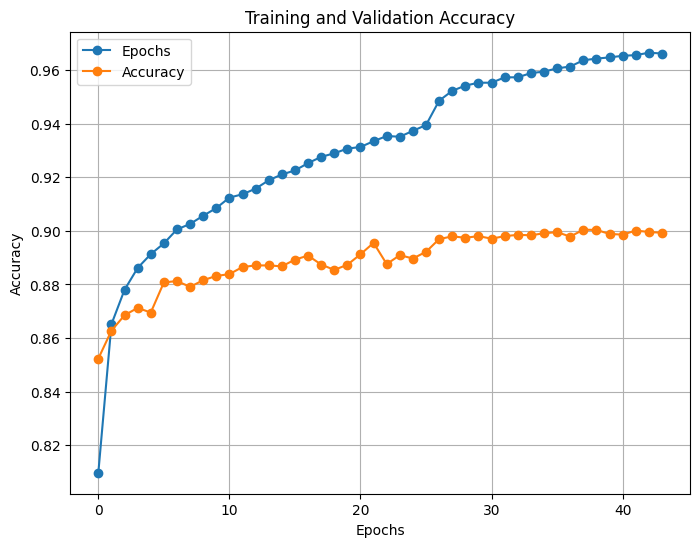

loss was: 1.5685317265987395  accuracy was: 0.8933

{'f1': 0.8930742811416275, 'recall': 0.8933, 'precision': 0.8930617764125823, 'accuracy': 0.8933}


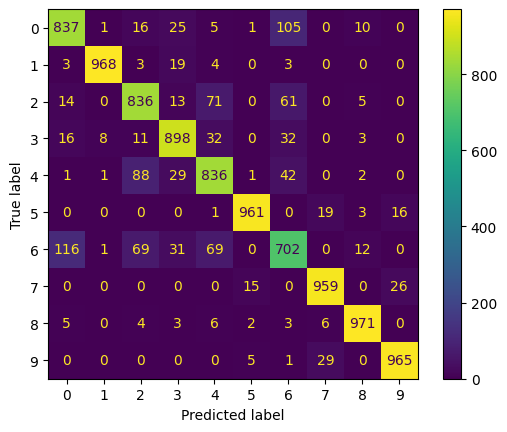

In [14]:
early_stopper =  EarlyStopping("./task2.pth", parameters['early_stopper'])
results_task2_fashion, task2_mat_fashion = execute_pipeline(model, data, parameters, early_stopper)
disp = ConfusionMatrixDisplay(confusion_matrix=task2_mat_fashion, display_labels=range(0, 10))
disp.plot()
plt.show()

In [4]:
# Task 3
from task1_aux import split_data_in_training_validation
SIZE = (28, 28)
BATCH_SIZE = 100

training_transforms = v2.Compose([
    ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=90),
    v2.RandomCrop(
      size=(SIZE),
      padding=(4, 4),
      padding_mode="reflect"),
    Resize(SIZE),
    Normalize(0.5, 0.5)
])

testing_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5)
])

training_no_transforms = v2.Compose([
    ToTensor()
])



X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
data = {
    "train": DataLoader(InfoLoaderDataset(X_train, y_train, 10, training_transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, testing_transforms), BATCH_SIZE, shuffle=True),
    "test":  DataLoader(InfoLoaderDataset(X_test, y_test, 10, testing_transforms), BATCH_SIZE, shuffle=True),
}

data_no_transform = {
    "train": DataLoader(InfoLoaderDataset(X_train, y_train, 10, training_no_transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, training_no_transforms), BATCH_SIZE, shuffle=True),
    "test":  DataLoader(InfoLoaderDataset(X_test, y_test, 10, training_no_transforms), BATCH_SIZE, shuffle=True),
}

In [16]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer):
        super(ConvBlock, self).__init__()
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.norm1(self.relu(self.conv1(x)))
        x = self.norm2(self.relu(self.conv2(x)))
        x = self.norm3(self.relu(self.conv3(x)))
        x += identity
        return self.relu(x)

class DeepConvNet(nn.Module):
    def __init__(self, channels, base_depth, expansion, nr_layer_blocks, num_classes=10):
        super(DeepConvNet, self).__init__()
        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(channels, self.base_depth, kernel_size=7, stride=2, padding=3,bias=False)
        self.relu = nn.ReLU(inplace=True)
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = nn.BatchNorm2d(depth1)
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, nn.BatchNorm2d)] * nr_layer_blocks
        )
        depth2 = depth1 * expansion
        self.conv_depth2 = conv1x1(depth1, depth2, 2)
        self.norm_depth2 = nn.BatchNorm2d(depth2)
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, nn.BatchNorm2d)] * nr_layer_blocks
        )
        depth3 = depth2 * expansion
        self.conv_depth3 = conv1x1(depth2, depth3, 2)
        self.norm_depth3 = nn.BatchNorm2d(depth3)
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, nn.BatchNorm2d)] * nr_layer_blocks
        )
        depth4 = depth3 * expansion
        self.conv_depth4 = conv1x1(depth3, depth4, 2)
        self.norm_depth4 = nn.BatchNorm2d(depth4)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(*[
            nn.Linear(depth4, depth3),
            nn.Dropout(0.3),
            nn.Linear(depth3, depth2),
            nn.Dropout(0.3),
            nn.Linear(depth2, num_classes)
        ])
    def forward(self, x):
        x = self.layer1(self.norm_depth1(self.conv_depth1(self.relu(self.conv1(x)))))
        x = self.layer2(self.norm_depth2(self.relu(self.conv_depth2(x))))
        x = self.layer3(self.norm_depth3(self.relu(self.conv_depth3(x))))
        x = self.avgpool(self.norm_depth4(self.relu(self.conv_depth4(x))))    
        return self.classification_layer(torch.flatten(x, 1))

In [27]:
parameters = {
    'epochs' : 50,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.1,
    'weight_decay_factor': 1e-4,
    'patience': 4,
    'base_depth': 16,
    'expansion': 4,
    'nr_layers_block': 2,
    'early_stopping' : 9
}

model = DeepConvNet(channels=1, base_depth=parameters['base_depth'], expansion=parameters['expansion'], 
                    nr_layer_blocks=parameters['nr_layers_block'])
for module in model.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")


Layer Type: DeepConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (conv_depth1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm_depth1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvBlock(
      (conv1): Conv2d(64, 16, kernel_size=(1, 1

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
1.270401620864868 0.543 epoch:  0
acuratete maxima la epoca 1
1.0250097334384918 0.6375833333333333 epoch:  1
acuratete maxima la epoca 2
0.8761865893999735 0.6836666666666666 epoch:  2
acuratete maxima la epoca 3
0.8012645676732063 0.7031666666666667 epoch:  3
acuratete maxima la epoca 4
0.7624306162198384 0.71925 epoch:  4
0.7729330832759539 0.71175 epoch:  5
acuratete maxima la epoca 6
0.7278804086148739 0.7315 epoch:  6
0.8077297508716583 0.686 epoch:  7
0.7209136205414931 0.7251666666666666 epoch:  8
0.7441878830393155 0.7261666666666666 epoch:  9
acuratete maxima la epoca 10
0.6593530351916949 0.7581666666666667 epoch:  10
0.6666134431958198 0.7541666666666667 epoch:  11
0.7731784373521805 0.7225 epoch:  12
0.6877072965105374 0.7455833333333334 epoch:  13
acuratete maxima la epoca 14
0.5671600468456746 0.7884166666666667 epoch:  14
0.611657819400231 0.767 epoch:  15
acuratete maxima la epoca 16
0.5411222845315933 0.797 epoch:  16
0.6353145209451516 0.7

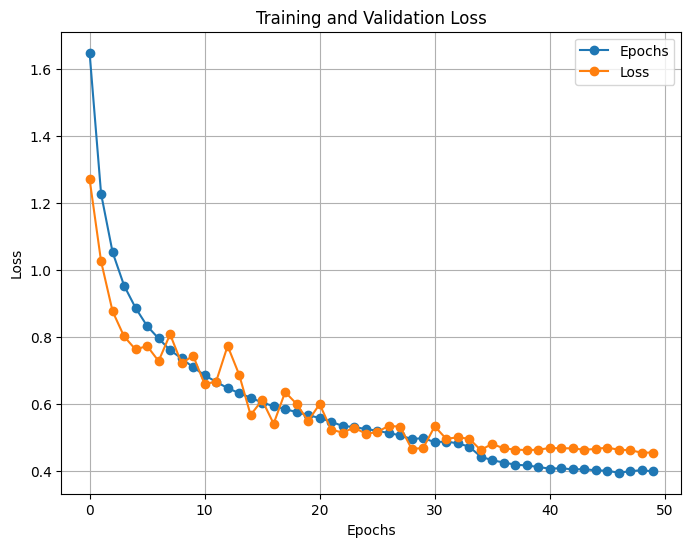

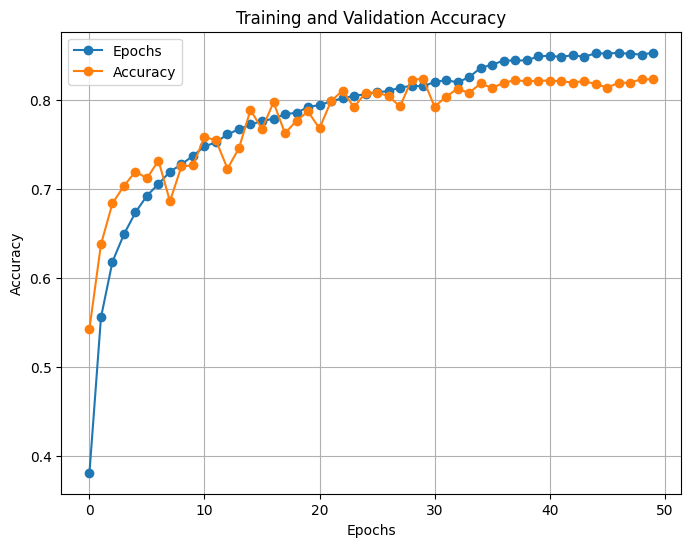

loss was: 0.4665071284770966  accuracy was: 0.8194

{'f1': 0.814671491082531, 'recall': 0.8194000000000001, 'precision': 0.8293799980226433, 'accuracy': 0.8194}


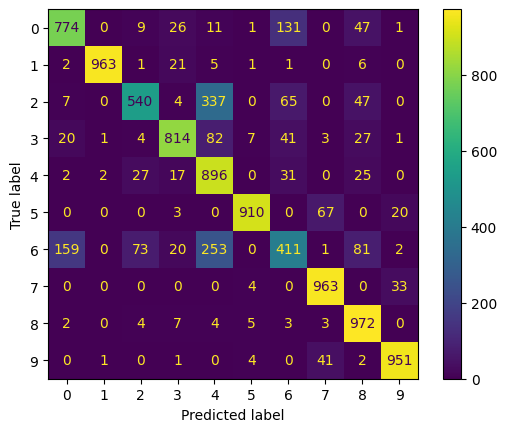

In [28]:
early_stopper =  EarlyStopping("./task3_transforms.pth", parameters['early_stopping'])
results_task3_transformations_fashion, task3_transformation_mat_fashion = execute_pipeline(model, data, parameters, early_stopper)
disp = ConfusionMatrixDisplay(confusion_matrix=task3_transformation_mat_fashion, display_labels=range(0, 10))
disp.plot()
plt.show()

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
0.9649779270092647 0.6681666666666667 epoch:  0
0.9848678459723791 0.66 epoch:  1
acuratete maxima la epoca 2
0.9545545553167661 0.691 epoch:  2
acuratete maxima la epoca 3
0.9239036033550898 0.7049166666666666 epoch:  3
acuratete maxima la epoca 4
0.9429789533217748 0.7058333333333333 epoch:  4
acuratete maxima la epoca 5
0.9246324141820271 0.71925 epoch:  5
acuratete maxima la epoca 6
0.9518700316548347 0.7231666666666666 epoch:  6
acuratete maxima la epoca 7
0.8905168453852336 0.7410833333333333 epoch:  7
acuratete maxima la epoca 8
0.8665624131759008 0.7526666666666667 epoch:  8
1.043719565620025 0.7304166666666667 epoch:  9
0.9532652368148168 0.7438333333333333 epoch:  10
acuratete maxima la epoca 11
0.907636588315169 0.7601666666666667 epoch:  11
0.9491843240956466 0.7594166666666666 epoch:  12
acuratete maxima la epoca 13
0.9178520674506824 0.7698333333333334 epoch:  13
acuratete maxima la epoca 14
0.8819239661097527 0.7725833333333333 epoch:  14
acur

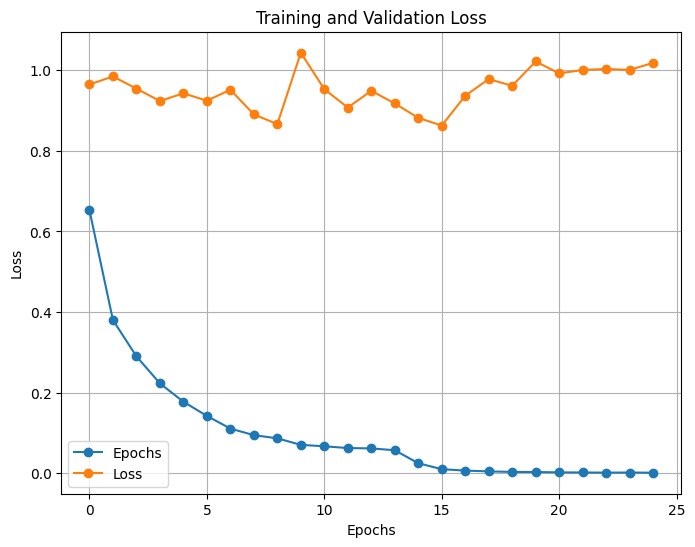

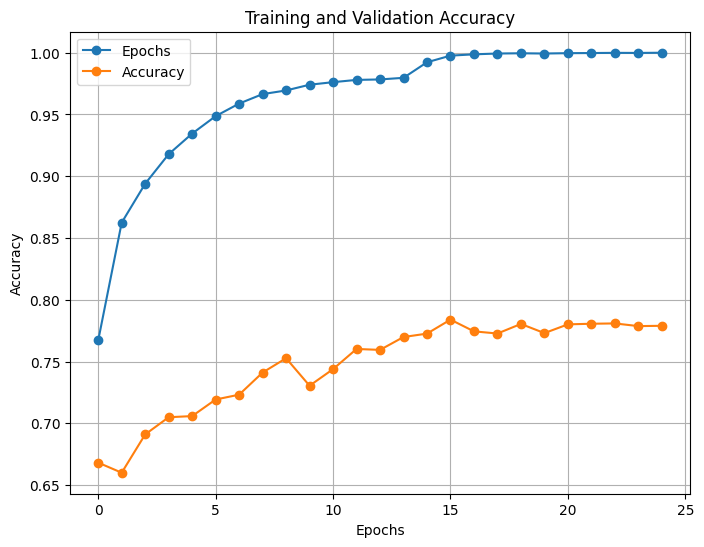

loss was: 0.8959157800674439  accuracy was: 0.7773

{'f1': 0.7800593920867432, 'recall': 0.7773000000000001, 'precision': 0.8046524145818035, 'accuracy': 0.7773}


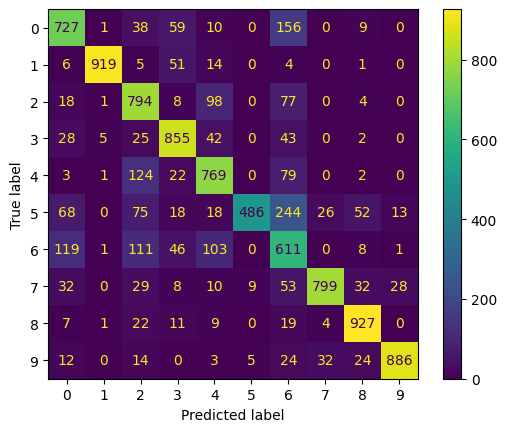

In [36]:
parameters = {
    'epochs' : 50,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.1,
    'weight_decay_factor': 1e-4,
    'patience': 4,
    'base_depth': 16,
    'expansion': 4,
    'nr_layers_block': 2,
    'early_stopping' : 9
}

model = DeepConvNet(channels=1, base_depth=parameters['base_depth'], expansion=parameters['expansion'], 
                    nr_layer_blocks=parameters['nr_layers_block'])
early_stopper =  EarlyStopping("./task3_transforms.pth", parameters['early_stopping'])
results_task3_no_transformations_fashion, task3_no_transformation_mat_fashion = execute_pipeline(model, data_no_transform, parameters, early_stopper)
disp = ConfusionMatrixDisplay(confusion_matrix=task3_no_transformation_mat_fashion, display_labels=range(0, 10))
disp.plot()
plt.show()

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
0.870938744644324 0.707 epoch:  0
acuratete maxima la epoca 1
0.7317659467458725 0.7449166666666667 epoch:  1
acuratete maxima la epoca 2
0.6102907297511896 0.7910833333333334 epoch:  2
acuratete maxima la epoca 3
0.5847003489732743 0.7995833333333333 epoch:  3
acuratete maxima la epoca 4
0.5694139574964842 0.80775 epoch:  4
acuratete maxima la epoca 5
0.5518486263851324 0.8085833333333333 epoch:  5
acuratete maxima la epoca 6
0.48708773652712506 0.83375 epoch:  6
acuratete maxima la epoca 7
0.4599296030898889 0.8400833333333333 epoch:  7
acuratete maxima la epoca 8
0.4618253119289875 0.8429166666666666 epoch:  8
acuratete maxima la epoca 9
0.45063308576742805 0.84775 epoch:  9
0.44826360295216244 0.8456666666666667 epoch:  10
acuratete maxima la epoca 11
0.41257816466192404 0.85975 epoch:  11
acuratete maxima la epoca 12
0.4026829045265913 0.8618333333333333 epoch:  12
0.4089851328482231 0.8595833333333334 epoch:  13
acuratete maxima la epoca 14
0.392192507

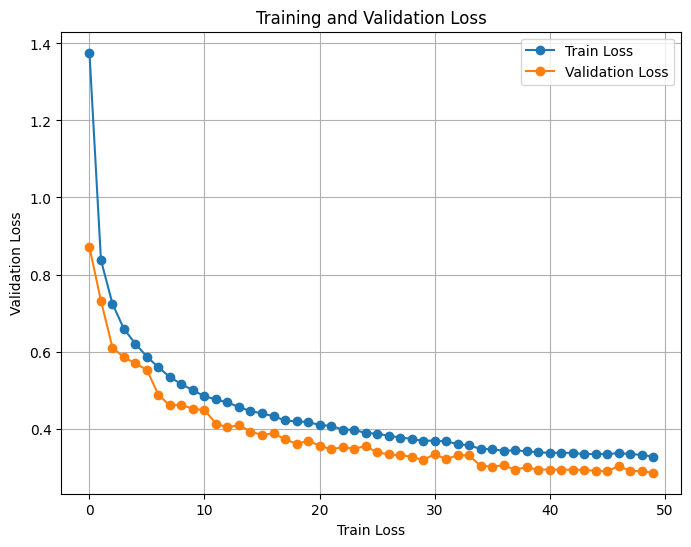

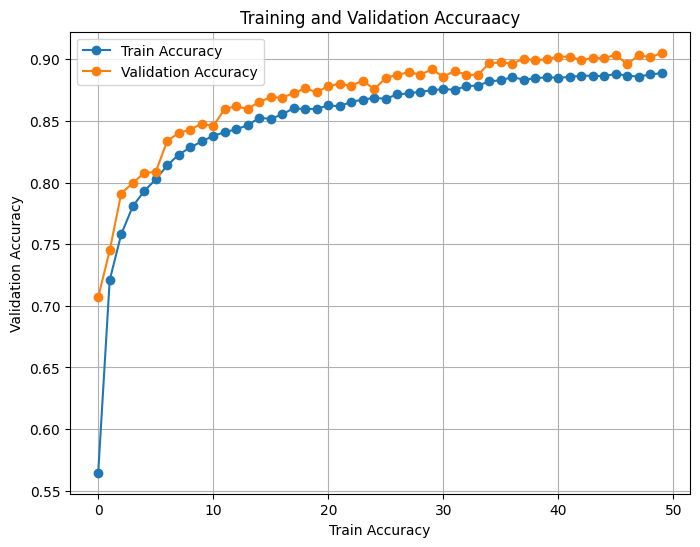

loss was: 0.3105180409550667  accuracy was: 0.8929

{'f1': 0.8912835108376793, 'recall': 0.8929, 'precision': 0.8915985847284464, 'accuracy': 0.8929}


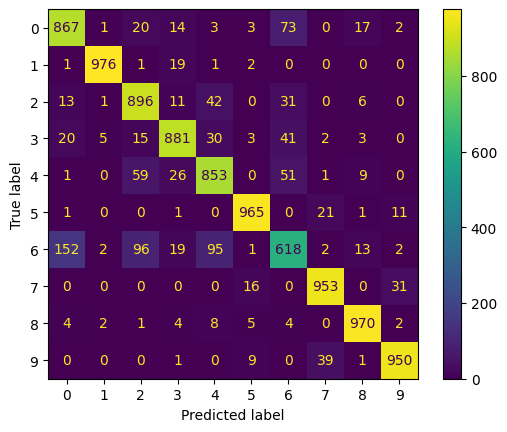

In [ ]:
# Task 4
from resnet import resnet18
model = resnet18()
model.load_state_dict(torch.load("./resnet18.pt", weights_only=True))
SIZE = (32, 32)
BATCH_SIZE = 100

training_task_4 = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=90),
    v2.RandomCrop(
      size=(SIZE),
      padding=(4, 4),
      padding_mode="reflect"),
    Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616]),
])

testing_task_4 = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616]),
])

def training_transforms(image : np.array):
    image = np.expand_dims(image, axis=2)
    image = np.concatenate((image, image, image), axis=2)
    return training_task_4(image)

def testing_transforms(image : np.array):
    image = np.expand_dims(image, axis=2)
    image = np.concatenate((image, image, image), axis=2)
    return testing_task_4(image)


X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
data = {
    "train": DataLoader(InfoLoaderDataset(X_train, y_train, 10, training_transforms), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, testing_transforms), BATCH_SIZE, shuffle=True),
    "test":  DataLoader(InfoLoaderDataset(X_test, y_test, 10, testing_transforms), BATCH_SIZE, shuffle=True),
}

parameters = {
    'epochs' : 50,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.4,
    'weight_decay_factor': 1e-4,
    'patience': 3,
    'base_depth': 16,
    'early_stopping': 5, # inainte 9
    'momentum': 0.5,
}

early_stopper =  EarlyStopping("./task4.pth", parameters['early_stopping'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=parameters['lr_optimizer'], momentum=parameters['momentum'],
                             weight_decay=parameters['weight_decay_factor'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                    factor=parameters['gamma_lr'], patience=parameters['patience'], verbose=True)
train_info = train_model(model, data, criterion, optimizer,
                             lr_scheduler, parameters['epochs'], early_stopper)
plot_losses(train_info["train_loss"], train_info["validation_loss"], "Train Loss", "Validation Loss", "Training and Validation Loss")
plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], "Train Accuracy", "Validation Accuracy", "Training and Validation Accuraacy")
model = early_stopper.load_model(model)
results_task4_fashion, task4_mat_fashion = test_model(model, data["test"], criterion, for_fruits=False)
disp = ConfusionMatrixDisplay(confusion_matrix=task4_mat_fashion, display_labels=range(0, 10))
disp.plot()
plt.show()
# 28 de minute antrenarea

In [ ]:
import pandas as pd
def compute_results():
    all_info = [results_task2_fashion, results_task3_transformations_fashion,
                results_task3_no_transformations_fashion, results_task4_fashion]
    data = {
        # "Features MLP",
        "names": ["MLP Full Image", "DeepConv Trasformation", "DeepConv No Transforms", "Pretrained Resnet18"],
        "f1": np.zeros(len(all_info)),
        "recall": np.zeros(len(all_info)),
        "precision": np.zeros(len(all_info)),
        "accuracy": np.zeros(len(all_info)),
    }

    for idx, info in enumerate(all_info):
        data["f1"][idx] = info["f1"]
        data["recall"][idx] = info["recall"]
        data["precision"][idx] = info["precision"]
        data["accuracy"][idx] = info["accuracy"]
    return pd.DataFrame(data)

df = compute_results()
df

In [5]:
fruits_train_path = "fruits-360_dataset_100x100/fruits-360/Training"
fruits_test_path = "fruits-360_dataset_100x100/fruits-360/Test"
import cv2

def get_all_paths_labels_fruits(path : str):
    fruit_train_directories = os.listdir(path)
    fruit_train_directories.sort()
    paths_list = []
    label_list = []
    for idx, directory in enumerate(fruit_train_directories):
        directory_path = path + "/" + directory
        for file_path in os.listdir(directory_path):
            paths_list.append(directory_path + "/" + file_path)
            label_list.append(idx)
    return paths_list, np.array(label_list)



def split_fruits_training_validation(paths, labels, split_factor):
    keys = np.unique(labels)
    training = []
    validation = []
    training_labels = []
    validation_labels = []
    for key in keys:
        indices = labels == key
        current_values = list(filter(lambda x : indices[x[0]], enumerate(paths)))
        current_values = list(map(lambda x : x[1], current_values))
        training_size = int(len(current_values) * (1 - split_factor))
        training.extend(current_values[:training_size])
        validation.extend(current_values[training_size:])
        training_labels += [key] * training_size
        validation_labels += [key] * (len(current_values) - training_size)
    return training, np.array(training_labels, dtype=np.uint8), validation, np.array(validation_labels, dtype=np.uint8)


class FruitDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.transform = transform
        self.paths = paths
        self.labels = labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if (self.transform == None):
            return cv2.imread(self.paths[idx]), self.labels[idx]
        return self.transform(cv2.imread(self.paths[idx])), self.labels[idx]

paths, labels = get_all_paths_labels_fruits(fruits_train_path)
FRUITS_CLASSES = np.unique(labels)
X_train, y_train, X_validation, y_validation = split_fruits_training_validation(paths, labels, 0.2)
X_test, y_test = get_all_paths_labels_fruits(fruits_test_path)
print(len(X_train), y_train.shape, len(X_validation), y_validation.shape, len(X_test), y_test.shape)

56348 (56348,) 14143 (14143,) 23619 (23619,)


In [29]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from task1_aux import compute_vocabulary, create_initial_features, compute_attributes
pd.set_option("display.precision", 15)

matrix_transforms = v2.Compose([
    ToTensor(),
    Resize((64, 64)),
    Normalize(0.5, 0.5),
])

def transforms(img : np.array):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return matrix_transforms(img)

FRUITS_BATCH_SIZE = 200
data = {
 "train": DataLoader(FruitDataset(paths, labels, transform=transforms), batch_size=FRUITS_BATCH_SIZE, shuffle=True),
 "test": DataLoader(FruitDataset(X_test, y_test, transform=transforms), batch_size=FRUITS_BATCH_SIZE, shuffle=True)
} 

vocabulary = compute_vocabulary(data["train"], 5)
print(vocabulary.shape)

rf = RandomForestClassifier(n_estimators=100, random_state=42)


a ajuns la epoca: 0
a ajuns la epoca: 100
a ajuns la epoca: 200
a ajuns la epoca: 300
(1765, 36)


In [30]:
for i in range(0, 2):
    X_train_features, y_train_features = create_initial_features(data["train"], vocabulary)
    print(X_train_features.shape, y_train_features.shape)
    print("a terminat cu datele de train")
    X_test_features, y_test_features = create_initial_features(data["test"], vocabulary)
    print(X_test_features.shape, y_test_features.shape)
    print("a terminat cu datele de test")
    rf.fit(X_train_features[:len(y_train_features)], y_train_features)
    accuracy_before = rf.score(X_test_features[:len(y_test_features)], y_test_features)
    print(f'accuracy after one more step', accuracy_before)
    feature_importance_df = pd.DataFrame({'Feature': range(len(rf.feature_importances_)), 'Importance': rf.feature_importances_})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    if (i == 0):
        top_features = feature_importance_df['Feature'][:500].values
    if (i == 1):
        top_features = feature_importance_df['Feature'][:128].values
    vocabulary = vocabulary[top_features]
    print(X_train_features.shape, y_train_features.shape)

(70491, 1765) (70491,)
a terminat cu datele de train
(23619, 1765) (23619,)
a terminat cu datele de test
accuracy after one more step 0.29755705152631357
(70491, 1765) (70491,)
(70491, 500) (70491,)
a terminat cu datele de train
(23619, 500) (23619,)
a terminat cu datele de test
accuracy after one more step 0.31250264617468987
(70491, 500) (70491,)


In [31]:
    
X_train_features, y_train_features, X_validation_features, y_validation_features, X_test_features, y_test_features = compute_attributes(vocabulary,
                            data["train"],  data["test"], FRUITS_CLASSES, VALIDATION)
BATCH_SIZE = 200

data = {
    "train":  DataLoader(InfoLoaderDataset(X_train_features, y_train_features, len(FRUITS_CLASSES)), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(InfoLoaderDataset(X_validation_features, y_validation_features, len(FRUITS_CLASSES)), BATCH_SIZE, shuffle=True),
    "test": DataLoader(InfoLoaderDataset(X_test_features, y_test_features, len(FRUITS_CLASSES)), BATCH_SIZE, shuffle=True),
}


(70491, 128) (70491,)
(23619, 128) (23619,)


In [32]:
parameters = {
    'expansion': 3,
    'epochs' : 100,
    'lr_optimizer': 1e-5,
    'gamma_lr': 0.3,
    'weight_decay_factor': 1e-5,
    'patience': 3,
    'early_stopper': 6,
}
early_stopper = EarlyStopping("./task1.pth", parameters['early_stopper'])
model = FeaturesMLP(expansion=parameters['expansion'], initial_features=128, num_classes=len(FRUITS_CLASSES))
for module in model.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")


Layer Type: FeaturesMLP(
  (fc1): Linear(in_features=128, out_features=384, bias=True)
  (bn1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=384, out_features=1152, bias=True)
  (bn2): BatchNorm1d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1152, out_features=3456, bias=True)
  (bn3): BatchNorm1d(3456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=3456, out_features=1152, bias=True)
  (bn4): BatchNorm1d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=1152, out_features=384, bias=True)
  (bn5): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=384, out_features=128, bias=True)
  (bn6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc7): Linear(in_features=128, out_features=141, bia

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
4.895467247761471 0.10386763770062929 epoch:  0
acuratete maxima la epoca 1
4.866613421641605 0.1339178392137453 epoch:  1
acuratete maxima la epoca 2
4.847384761756574 0.15824082585024393 epoch:  2
acuratete maxima la epoca 3
4.835399170996437 0.1703316128119918 epoch:  3
acuratete maxima la epoca 4
4.824156432084634 0.18242239977373967 epoch:  4
acuratete maxima la epoca 5
4.810741961841852 0.19684649650003536 epoch:  5
acuratete maxima la epoca 6
4.800016470358405 0.20801810082726438 epoch:  6
acuratete maxima la epoca 7
4.792055049412687 0.21728063352895424 epoch:  7
acuratete maxima la epoca 8
4.7847459819954885 0.22604822173513398 epoch:  8
acuratete maxima la epoca 9
4.779210607770463 0.23545216714982678 epoch:  9
acuratete maxima la epoca 10
4.771050453186035 0.244926818921021 epoch:  10
acuratete maxima la epoca 11
4.766196324791707 0.25383581984020365 epoch:  11
acuratete maxima la epoca 12
4.758613586425781 0.2601286855688326 epoch:  12
acuratete 

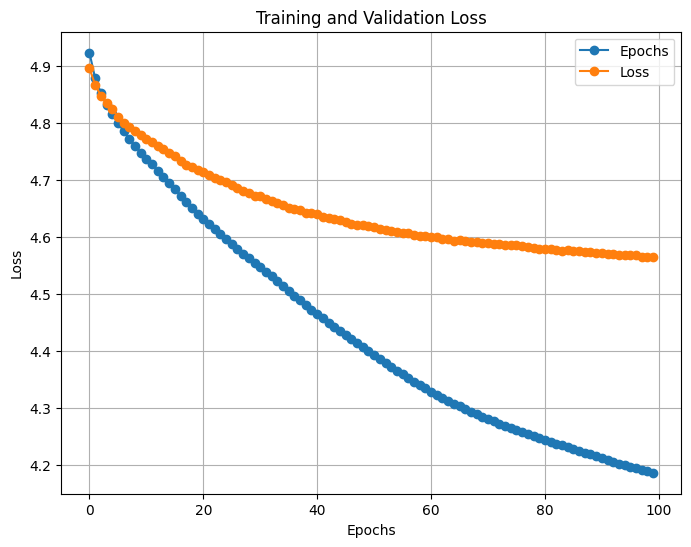

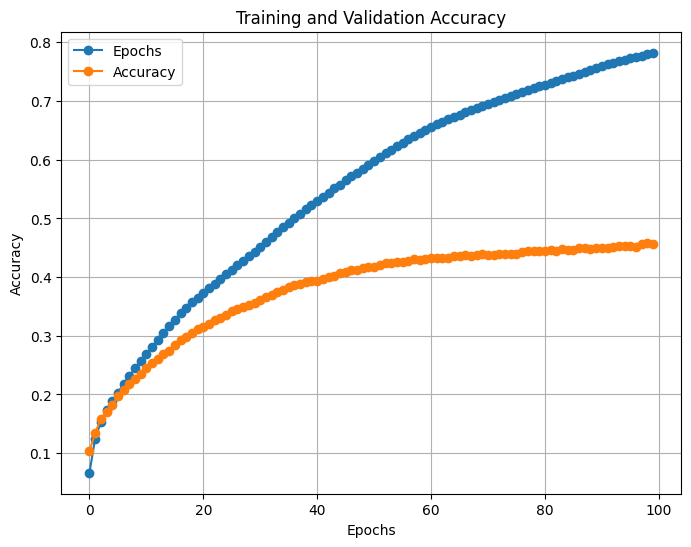

loss was: 4.70145772485172  accuracy was: 0.29823447224691985

{'f1': 0.16452331763763084, 'recall': 0.17004100706231642, 'precision': 0.1829757888200322, 'accuracy': 0.29823447224691985}


/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
results_task1_fashion, task1_mat_fashion = execute_pipeline(model, data, parameters, early_stopper)

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
4.592866484548004 0.4228240118786679 epoch:  0
acuratete maxima la epoca 1
4.3525592844251175 0.6751042918758396 epoch:  1
acuratete maxima la epoca 2
4.181437052471537 0.8189917273562893 epoch:  2
acuratete maxima la epoca 3
4.08350937131425 0.9033444106625186 epoch:  3
acuratete maxima la epoca 4
4.040070716763886 0.9372834617832143 epoch:  4
acuratete maxima la epoca 5
4.016497361827904 0.9548893445520752 epoch:  5
acuratete maxima la epoca 6
4.0008770580023105 0.9686770840698579 epoch:  6
acuratete maxima la epoca 7
3.989324462245887 0.9819698790921304 epoch:  7
acuratete maxima la epoca 8
3.9772234802514737 0.987414268542742 epoch:  8
acuratete maxima la epoca 9
3.975886338193652 0.9899596973767941 epoch:  9
acuratete maxima la epoca 10
3.9729285928565012 0.9915859435763276 epoch:  10
acuratete maxima la epoca 11
3.9700636611857885 0.993070777062858 epoch:  11
acuratete maxima la epoca 12
3.96927032000582 0.9951212614014 epoch:  12
acuratete maxima la e

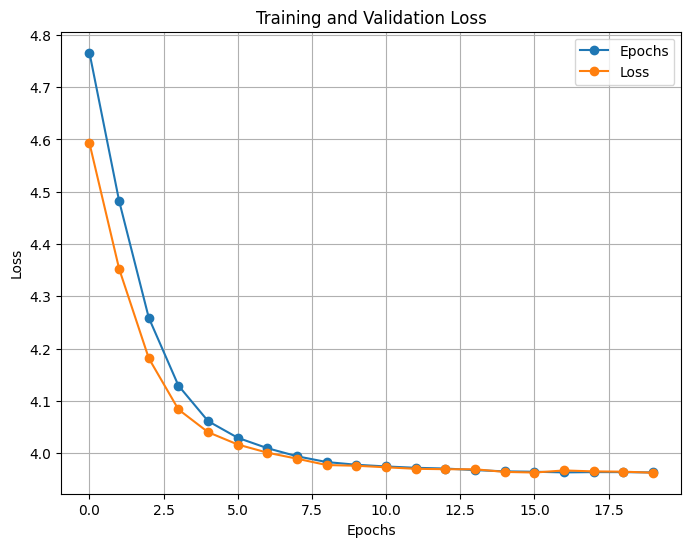

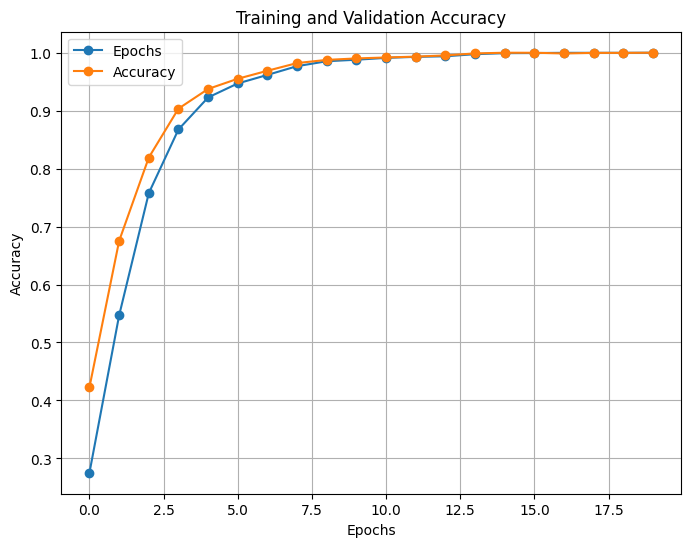

loss was: 4.024804131391179  accuracy was: 0.9585926584529404

{'f1': 0.928587654497379, 'recall': 0.9234899212434515, 'precision': 0.9468028105620638, 'accuracy': 0.9585926584529404}


In [ ]:
SIZE = (28, 28)
BATCH_SIZE = 100

transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5),
])

paths, labels = get_all_paths_labels_fruits(fruits_train_path)
FRUITS_CLASSES = np.unique(labels)
X_train, y_train, X_validation, y_validation = split_fruits_training_validation(paths, labels, 0.2)
X_test, y_test = get_all_paths_labels_fruits(fruits_test_path)

# 6 minute si 46,3 secunde
model = FullImageMLP(input_size=28 * 28 * 3, num_hidden_layers=200, num_classes=len(FRUITS_CLASSES))
data = {
 "train": DataLoader(FruitDataset(X_train, y_train, transforms), batch_size=BATCH_SIZE, shuffle=True),
 "validation": DataLoader(FruitDataset(X_validation, y_validation, transforms), batch_size=BATCH_SIZE, shuffle=True),
 "test": DataLoader(FruitDataset(X_test, y_test, transforms), batch_size=BATCH_SIZE, shuffle=True)
} 

parameters = {
    'epochs' : 20,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.5,
    'weight_decay_factor': 1e-4,
    'patience': 3,
    'early_stopper': 6,
}

early_stopper =  EarlyStopping("./task2_fruits.pth", parameters['early_stopper'])
results_task2_fashion = execute_pipeline(model, data, parameters, early_stopper, True)

Layer Type: DeepConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (conv_depth1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm_depth1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvBlock(
      (conv1): Conv2d(64, 16, kernel_size=(1, 1

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
1.1117398629725819 0.6398925263381178 epoch:  0
acuratete maxima la epoca 1
0.6495391250076429 0.7810224139150109 epoch:  1
acuratete maxima la epoca 2
0.5228145328206075 0.825708831223927 epoch:  2
acuratete maxima la epoca 3
0.4172774646693552 0.8556176200240402 epoch:  3
0.5659064075476686 0.8235169341723821 epoch:  4
0.5625606229607488 0.8202644417733154 epoch:  5
acuratete maxima la epoca 6
0.30704993901538175 0.884536519833133 epoch:  6
acuratete maxima la epoca 7
0.2896046127441903 0.8979707275684083 epoch:  7
0.4029952901559816 0.8759103443399562 epoch:  8
0.33585348735812687 0.890829385561762 epoch:  9
0.33910476846594206 0.8875768931626953 epoch:  10
acuratete maxima la epoca 11
0.20240190011304868 0.9330410803931274 epoch:  11
0.27020762189173364 0.9095665700346461 epoch:  12
0.2981147222011022 0.9067383157745882 epoch:  13
acuratete maxima la epoca 14
0.1539616931072423 0.9506469631619883 epoch:  14
0.2143036571501846 0.9234957222654316 epoch:  1

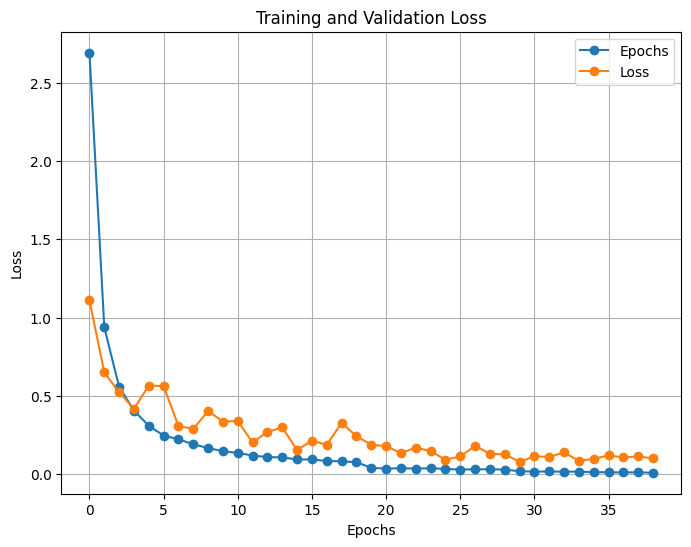

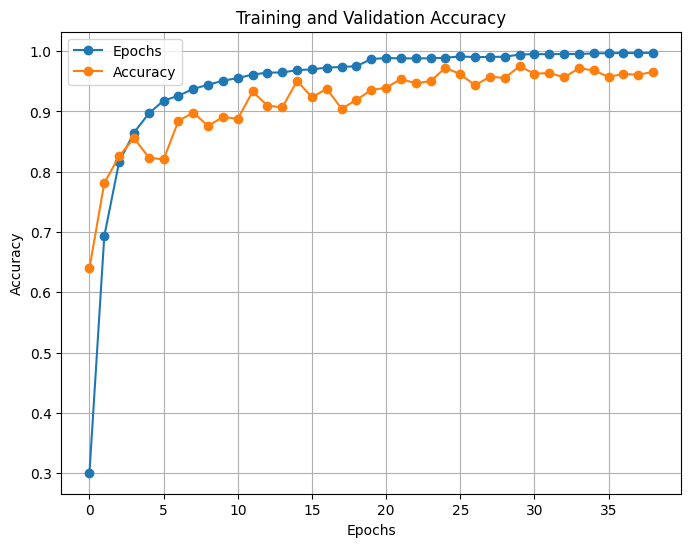

loss was: 0.2855943170403629  accuracy was: 0.9154070875142893

{'f1': 0.8503635413870377, 'recall': 0.8815362741926899, 'precision': 0.8723580408975394, 'accuracy': 0.9154070875142893}


In [19]:
SIZE = (28, 28)
BATCH_SIZE = 100

training_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=90),
    v2.RandomCrop(
      size=(SIZE),
      padding=(4, 4),
      padding_mode="reflect"),
    Normalize(0.5, 0.5)
])

testing_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5)
])

paths, labels = get_all_paths_labels_fruits(fruits_train_path)
FRUITS_CLASSES = np.unique(labels)
X_train, y_train, X_validation, y_validation = split_fruits_training_validation(paths, labels, 0.2)
X_test, y_test = get_all_paths_labels_fruits(fruits_test_path)


data = {
 "train": DataLoader(FruitDataset(X_train, y_train, training_transforms), batch_size=BATCH_SIZE, shuffle=True),
 "validation": DataLoader(FruitDataset(X_validation, y_validation, testing_transforms), batch_size=BATCH_SIZE, shuffle=True),
 "test": DataLoader(FruitDataset(X_test, y_test, testing_transforms), batch_size=BATCH_SIZE, shuffle=True)
} 


parameters = {
    'epochs' : 50,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.5,
    'weight_decay_factor': 1e-4,
    'patience': 3,
    'early_stopper': 9,
    'expansion': 4,
    'nr_layers_block': 2,
    'base_depth': 16,
}

model = DeepConvNet(channels=3, base_depth= parameters['base_depth'], expansion= parameters['expansion'],
                 nr_layer_blocks=parameters['nr_layers_block'], num_classes=len(FRUITS_CLASSES))
for module in model.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")
early_stopper =  EarlyStopping("./task2_fruits.pth", parameters['early_stopper'])
results_task2_fashion = execute_pipeline(model, data, parameters, early_stopper, True)

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
1.6452943346869777 0.5524287633458248 epoch:  0
acuratete maxima la epoca 1
1.41965151294856 0.612387753659054 epoch:  1
acuratete maxima la epoca 2
1.3422184024058597 0.6428621933111787 epoch:  2
1.505571056419695 0.6225694689952627 epoch:  3
acuratete maxima la epoca 4
1.227684153637416 0.6778618397793962 epoch:  4
acuratete maxima la epoca 5
0.9060715604835833 0.7496994979848688 epoch:  5
acuratete maxima la epoca 6
0.8104629718082051 0.7723962384218341 epoch:  6
acuratete maxima la epoca 7
0.7981214504426634 0.7803153503499964 epoch:  7
acuratete maxima la epoca 8
0.7389630794944898 0.7863960970091212 epoch:  8
acuratete maxima la epoca 9
0.6771289158455083 0.8078908293855618 epoch:  9
0.8680231705517836 0.7538711730184544 epoch:  10
acuratete maxima la epoca 11
0.5146650323565577 0.8523651276249735 epoch:  11
0.746211054879175 0.7938202644417733 epoch:  12
acuratete maxima la epoca 13
0.5239036083221436 0.8578802234320866 epoch:  13
acuratete maxima la 

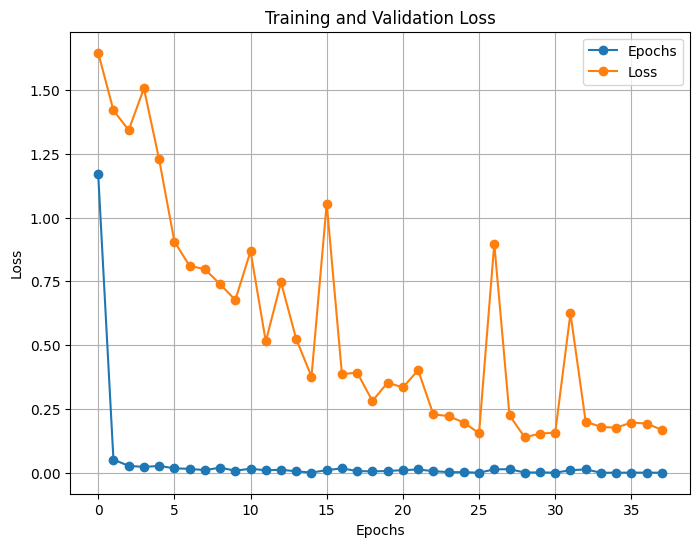

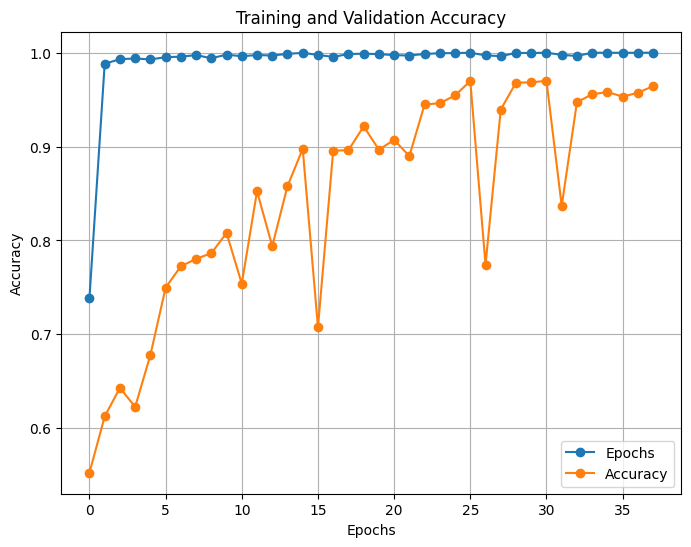

loss was: 0.5584320908860315  accuracy was: 0.8646428722638554

{'f1': 0.8381393011820762, 'recall': 0.8593685754025255, 'precision': 0.8363694911495083, 'accuracy': 0.8646428722638554}


In [22]:

paths, labels = get_all_paths_labels_fruits(fruits_train_path)
FRUITS_CLASSES = np.unique(labels)
X_train, y_train, X_validation, y_validation = split_fruits_training_validation(paths, labels, 0.2)
X_test, y_test = get_all_paths_labels_fruits(fruits_test_path)

transforms_necessary = v2.Compose([
    ToTensor(),
    Resize((28, 28))
])

data = {
 "train": DataLoader(FruitDataset(X_train, y_train, transforms_necessary), batch_size=BATCH_SIZE, shuffle=True),
 "validation": DataLoader(FruitDataset(X_validation, y_validation, transforms_necessary), batch_size=BATCH_SIZE, shuffle=True),
 "test": DataLoader(FruitDataset(X_test, y_test, transforms_necessary), batch_size=BATCH_SIZE, shuffle=True)
} 


parameters = {
    'epochs' : 50,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.5,
    'weight_decay_factor': 1e-4,
    'patience': 3,
    'early_stopper': 9,
    'expansion': 4,
    'nr_layers_block': 2,
    'base_depth': 16,
}

model = DeepConvNet(channels=3, base_depth= parameters['base_depth'], expansion= parameters['expansion'],
                 nr_layer_blocks=parameters['nr_layers_block'], num_classes=len(FRUITS_CLASSES))
early_stopper =  EarlyStopping("./task2_fruits.pth", parameters['early_stopper'])
results_task2_fashion = execute_pipeline(model, data, parameters, early_stopper, True)

/home/alf/anul4/tema2IA/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


acuratete maxima la epoca 0
4.370007504879589 0.04291875839637983 epoch:  0
acuratete maxima la epoca 1
4.012992585209054 0.10676659831718871 epoch:  1
acuratete maxima la epoca 2
3.7487796511448606 0.1798769709396875 epoch:  2
acuratete maxima la epoca 3
3.5484750472323996 0.2410379693134413 epoch:  3
acuratete maxima la epoca 4
3.4010096603715922 0.2906031252209574 epoch:  4
acuratete maxima la epoca 5
3.2932946127904974 0.3199462631690589 epoch:  5
acuratete maxima la epoca 6
3.196949414803948 0.3412995828324966 epoch:  6
acuratete maxima la epoca 7
3.0776345998468533 0.3849961111503924 epoch:  7
acuratete maxima la epoca 8
3.000091423451061 0.40776355794385916 epoch:  8
acuratete maxima la epoca 9
2.8965039118914535 0.4512479671922506 epoch:  9
acuratete maxima la epoca 10
2.8198005414344895 0.4683589054656014 epoch:  10
acuratete maxima la epoca 11
2.7288842553823764 0.4874496217209927 epoch:  11
acuratete maxima la epoca 12
2.6610639934808438 0.5088029413844305 epoch:  12
acurate

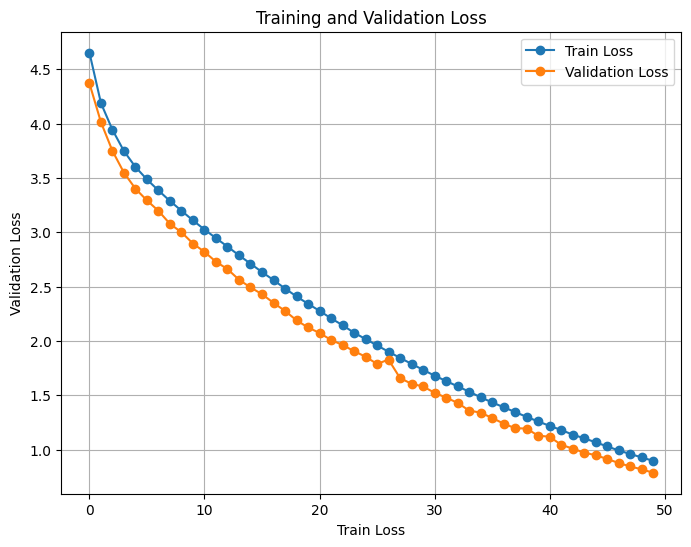

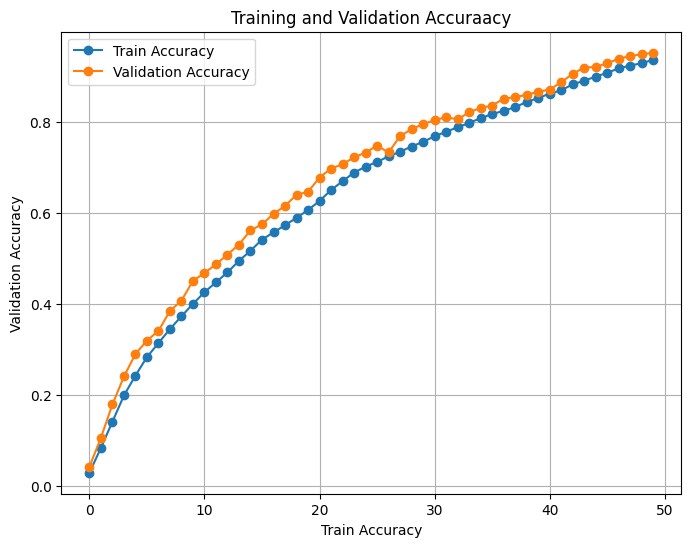

loss was: 0.9142303368713283  accuracy was: 0.9259071086836869

{'f1': 0.8928987924178144, 'recall': 0.8983973564989565, 'precision': 0.9531102712073795, 'accuracy': 0.9259071086836869}


In [27]:
from resnet import resnet18
class Task4FruitsResnet(nn.Module):
    def __init__(self, classes : int):
        super(Task4FruitsResnet, self).__init__()
        self.model = resnet18()
        self.model.load_state_dict(torch.load("./resnet18.pt", weights_only=True))
        self.lin1 = nn.Linear(10, classes)

    def forward(self, x):
        return self.lin1(self.model(x))

SIZE = (32, 32)
BATCH_SIZE = 100

training_task_4 = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=90),
    v2.RandomCrop(
      size=(SIZE),
      padding=(4, 4),
      padding_mode="reflect"),
    Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616]),
])

testing_task_4 = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616]),
])

paths, labels = get_all_paths_labels_fruits(fruits_train_path)
FRUITS_CLASSES = np.unique(labels)
X_train, y_train, X_validation, y_validation = split_fruits_training_validation(paths, labels, 0.2)
X_test, y_test = get_all_paths_labels_fruits(fruits_test_path)
model = Task4FruitsResnet(len(FRUITS_CLASSES))

data = {
    "train": DataLoader(FruitDataset(X_train, y_train, training_task_4), BATCH_SIZE, shuffle=True),
    "validation": DataLoader(FruitDataset(X_validation, y_validation, testing_task_4), BATCH_SIZE, shuffle=True),
    "test":  DataLoader(FruitDataset(X_test, y_test, testing_task_4), BATCH_SIZE, shuffle=True),
}

parameters = {
    'epochs' : 50,
    'lr_optimizer': 1e-4,
    'gamma_lr': 0.4,
    'weight_decay_factor': 1e-4,
    'patience': 3,
    'early_stopping': 5, 
    'momentum': 0.5,
}

early_stopper =  EarlyStopping("./task4.pth", parameters['early_stopping'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=parameters['lr_optimizer'], momentum=parameters['momentum'],
                             weight_decay=parameters['weight_decay_factor'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                    factor=parameters['gamma_lr'], patience=parameters['patience'], verbose=True)
train_info = train_model(model, data, criterion, optimizer,
                             lr_scheduler, parameters['epochs'], early_stopper)
plot_losses(train_info["train_loss"], train_info["validation_loss"], "Train Loss", "Validation Loss", "Training and Validation Loss")
plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], "Train Accuracy", "Validation Accuracy", "Training and Validation Accuraacy")
model = early_stopper.load_model(model)
results_task4_fruits = test_model(model, data["test"], criterion, for_fruits=True)